# Embedding Spaces for Xenium NSCLC Segger Model

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from importlib import reload
import requirements
reload(requirements)
from requirements import *
from segger.data.parquet._utils import (
    filter_transcripts,
    load_settings,
    read_parquet_region,
)
from segger.training.segger_data_module import SeggerDataModule
from segger.prediction.predict import load_model
from sg_utils.tl.phenograph_rapids import _run_phenograph
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.plot_segmentation_comparison import *
import celltypist as ct
import torch
from torch_geometric.data.batch import Batch

## Cell Type Labels

## Rebuild Cell Typist Model

In [421]:
# NSCLC Atlas
ad_nuc = sc.read_h5ad(data_dir / 'h5ads/10x_nucleus_id.h5ad')

In [425]:
# Filter to cells with high confidence
ad_nuc = ad_nuc[
    ad_nuc.obs['celltypist_probability'].gt(0.99) & 
    ad_nuc.obs['celltypist_entropy'].lt(0.01)
]

ad_nuc.layers['norm'] = ad_nuc.raw.X.copy()
sc.pp.normalize_total(ad_nuc, layer='norm')

# Logarthmize
ad_nuc.layers['lognorm'] = ad_nuc.layers['norm'].copy()
if 'log1p' in ad_nuc.uns:
    del ad_nuc.uns['log1p']
sc.pp.log1p(ad_nuc, layer='lognorm')

In [429]:
# Subsample using more granular cell types (to not lose any one cell type)
# But transfer labels using the compartment labels
gb = ad_nuc.obs.groupby('celltypist_label')
sample = gb.sample(2000, replace=True).index.drop_duplicates()

# Predict on log counts
ad_nuc.X = ad_nuc.layers['lognorm']
with HiddenPrints():
    ct_model = ct.train(
        ad_nuc[sample],
        labels='celltypist_label',
        check_expression=False,
        n_jobs=32,
        max_iter=100,
    )

ct_model.write(data_dir / '10x_nucleus_xenium_celltypist_model.pkl')

In [615]:
# Get top markers used for classification
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)

## Load Model

In [58]:
from typing import Tuple

def get_embedding(
    batch,
    node_type: str,
    edge_type: Tuple[str],
):
    with torch.no_grad():
        
        edge_index = batch[edge_type].edge_index
        x = batch[node_type].x
        x = torch.nan_to_num(x, nan=0)
        is_1d = float(x.ndim == 1)
        x = torch.unsqueeze(x, 1)
    
        f1 = model.model.tx_embedding[node_type]
        f2 = model.model.lin0[node_type]
        x = f1(x.sum(-1).int()) * is_1d + f2(x.float()) * (1 - is_1d)
        
        x = x.squeeze()
        x = x.relu()
        x = model.model.conv_first['__'.join(edge_type)](x, edge_index)
        x = x.cpu().detach()

    torch.cuda.empty_cache()
    
    return x

In [59]:
uid = 'HDE46PBXJB'
models_dir = Path(
    f'/data/peer/moormana/GitHub/dpeerlab/segger_dev/dev/figure_3_v2/data/'
    f'outputs/segger_v2/models/{uid}/lightning_logs/version_0/checkpoints'
)
model = load_model(models_dir)

In [60]:
datasets_dir = Path(
    f'/data/peer/moormana/GitHub/dpeerlab/segger_dev/dev/figure_3_v2/data/'
    f'outputs/segger_v3/datasets/{uid}'
)

In [168]:
import re
import glob

datasets = []

region = shapely.box(7000, 7000, 7500, 7500)

for filepath in tqdm(glob.glob(str(datasets_dir / '*_tiles/processed/*.pt'))):
    x, y, w, h = map(int, re.findall(r'=(\d+)', filepath))
    tile = shapely.box(x, y, x+w, y+h)
    if region.intersects(tile):
        data = torch.load(filepath)
        datasets.append(data)

#from torch_geometric.data.batch import Batch
#batch = Batch.from_data_list(datasets)

100%|██████████| 1920/1920 [00:01<00:00, 1540.06it/s]


In [280]:
node_type = 'tx'
edge_type = ('tx', 'neighbors', 'tx')
frac = 0.01

idx = torch.empty((0), dtype=torch.int64)
data = torch.empty((0, 64), dtype=float)

for d in tqdm(datasets):
    d.to('cuda')
    x = get_embedding(d, node_type, edge_type)
    d.to('cpu')
    data = torch.cat((data, x))
    idx = torch.cat([idx, d[node_type].id])

100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


In [167]:
# Read and filter transcripts
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    data_dir / 'labeled_transcripts.parquet',
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=[
        'feature_name', 'overlaps_nucleus', 'transcript_id', 
        'segger_cell_id_HDE46PBXJB', 'segger_score_HDE46PBXJB'
    ],
)
transcripts.set_index('transcript_id', inplace=True)

In [281]:
idx, uniques = np.unique(np.array(idx).astype('uint64'), return_index=True)
data = data[uniques]

In [282]:
mask = np.isin(idx, transcripts.index)
data = data[mask]
idx = idx[mask]
transcripts = transcripts.loc[idx]

In [172]:
# Run UMAP on data
model_umap = cuml.UMAP(min_dist=0.2, n_epochs=1000)
X_umap = model_umap.fit_transform(cp.array(data))
X_umap = X_umap.get()

In [173]:
transcripts['umap_x_l1'] = X_umap[:, 0]
transcripts['umap_y_l1'] = X_umap[:, 1]

In [174]:
# Cluster data
model_knn = cuml.NearestNeighbors(n_neighbors=10)
model_knn.fit(cp.array(data))
neighbors, indices = model_knn.kneighbors(cp.array(data))
clusters = _run_phenograph(indices, resolution=0.1)

In [175]:
transcripts['cluster_l1'] = pd.Categorical(clusters)

In [176]:
# Get top markers used for classification
ct_model = ct.Model.load(str(data_dir / '10x_nucleus_xenium_celltypist_model.pkl'))
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)
ct_map = coefs.idxmax(1)

# Color by cell type of transcript
transcripts['cell_type'] = pd.Categorical(
    transcripts['feature_name'].map(ct_map).fillna('Unassigned')
)

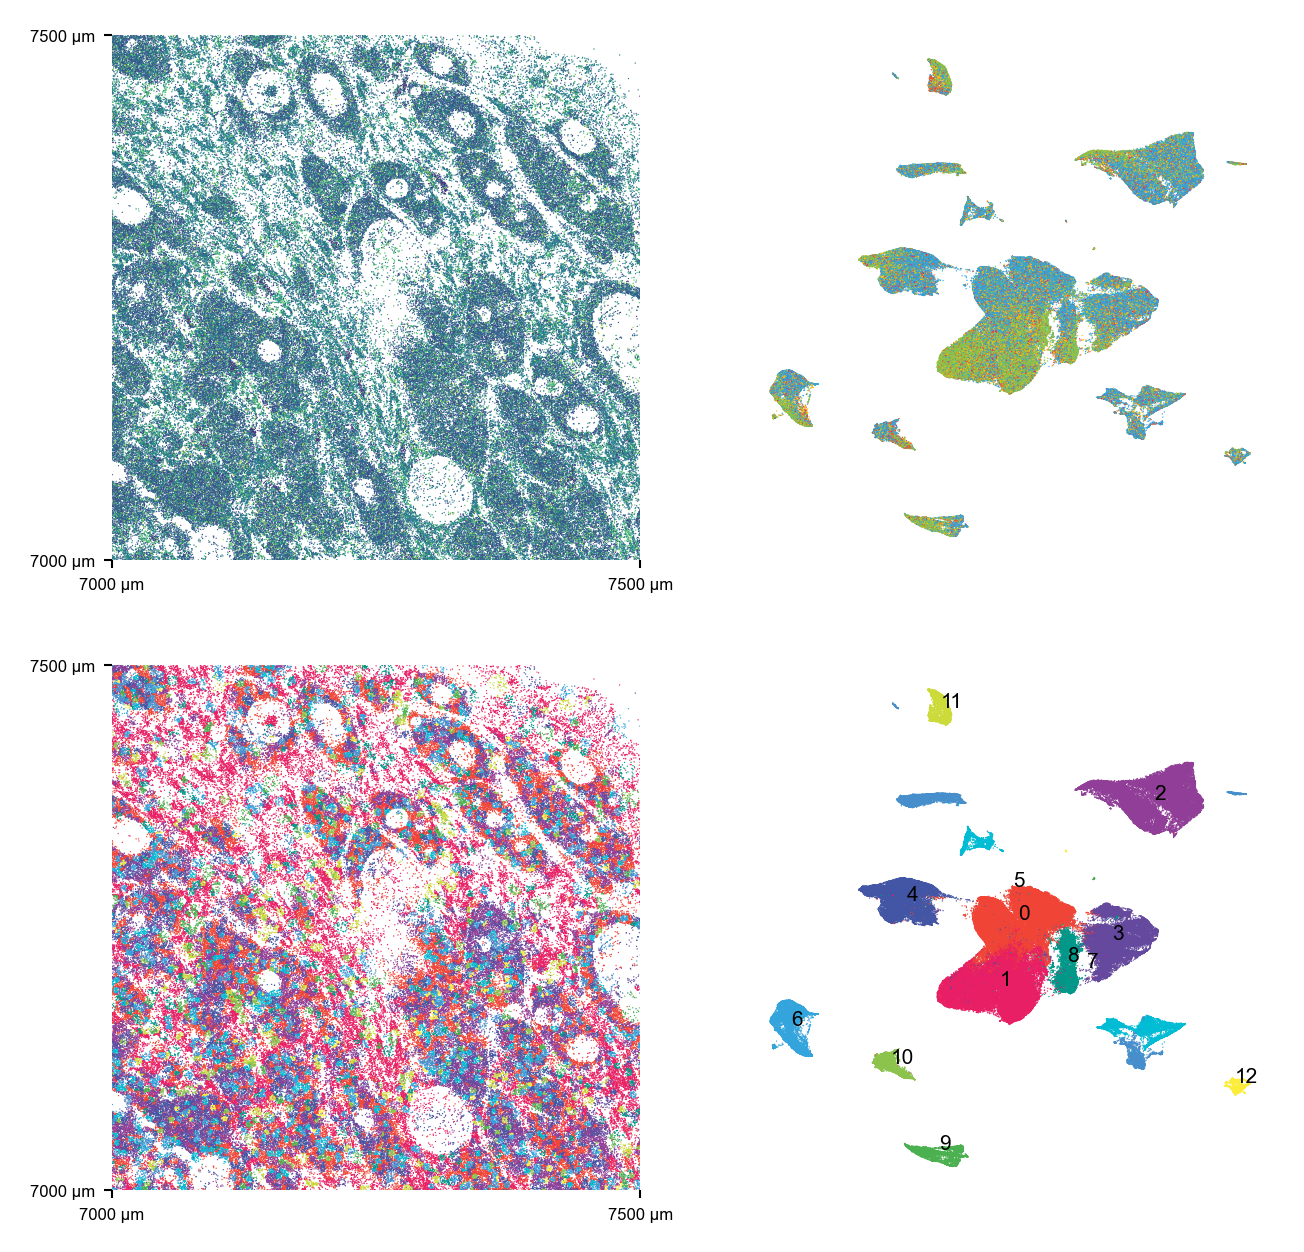

In [177]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flat

mask = transcripts['cluster_l1'] != -1

sns.scatterplot(
    transcripts[mask],
    x='umap_x_l1',
    y='umap_y_l1',
    hue='cell_type',
    s=0.1,
    lw=0,
    ax=axes[1],
    legend=False,
    palette=named_colors,
)
axes[1].axis('off')

sns.scatterplot(
    transcripts[mask],
    x='umap_x_l1',
    y='umap_y_l1',
    hue='cluster_l1',
    s=0.1,
    lw=0,
    ax=axes[3],
    legend=False,
)
axes[3].axis('off')
for name, group in transcripts[mask].groupby('cluster_l1', observed=True):
    axes[3].text(
        group['umap_x_l1'].mean(),
        group['umap_y_l1'].mean(),
        name,
        fontsize=5
    )

sns.scatterplot(
    transcripts[mask],
    x='x_location',
    y='y_location',
    hue='cell_type',
    s=0.1,
    lw=0,
    ax=axes[0],
    legend=False,
    palette='viridis', #named_colors,
)

sns.scatterplot(
    transcripts[mask],
    x='x_location',
    y='y_location',
    hue='cluster_l1',
    s=0.1,
    lw=0,
    ax=axes[2],
    legend=False,
)

xmin, ymin, xmax, ymax = region.bounds
for ax in (axes[0], axes[2]):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    format_ax(ax, region)

## Output Embedding

In [292]:
node_type = 'tx'
edge_type = ('tx', 'neighbors', 'tx')
frac = 0.01

idx = torch.empty((0), dtype=torch.int64)
data = torch.empty((0, 16), dtype=float)

for d in tqdm(datasets):
    batch = Batch.from_data_list([d])
    batch.to('cuda')
    with torch.no_grad():
        x = model.model(batch.x_dict, batch.edge_index_dict)[node_type]
    torch.cuda.empty_cache()
    batch.to('cpu')
    x = x.to('cpu')
    data = torch.cat((data, x))
    idx = torch.cat([idx, d[node_type].id])

100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


In [293]:
idx, uniques = np.unique(np.array(idx).astype('uint64'), return_index=True)
data = data[uniques]

In [294]:
mask = np.isin(idx, transcripts.index)
data = data[mask]
idx = idx[mask]
transcripts = transcripts.loc[idx]

In [354]:
# Run UMAP on data
model_umap = cuml.UMAP(min_dist=0.1, n_epochs=1000, n_neighbors=50)
X_umap = model_umap.fit_transform(cp.array(data))
X_umap = X_umap.get()

In [346]:
# Run UMAP on data
model_pca = cuml.PCA()
X_pca = model_pca.fit_transform(cp.array(data))
X_pca = X_pca.get()

[W] [20:55:59.363592] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


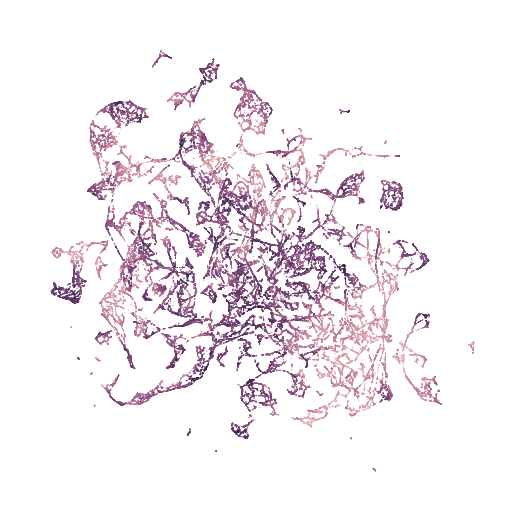

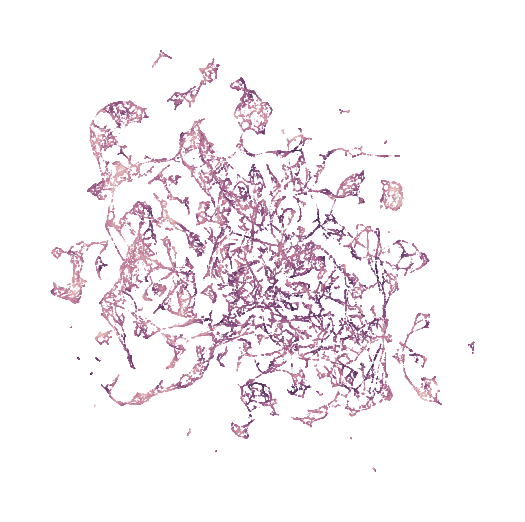

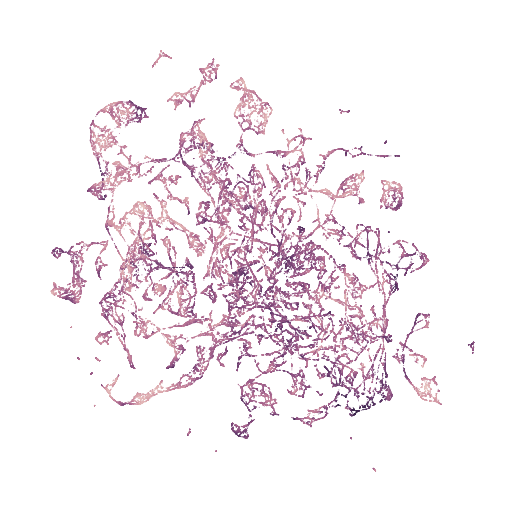

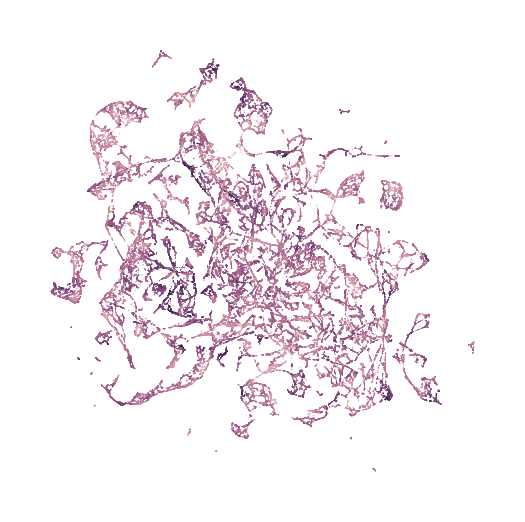

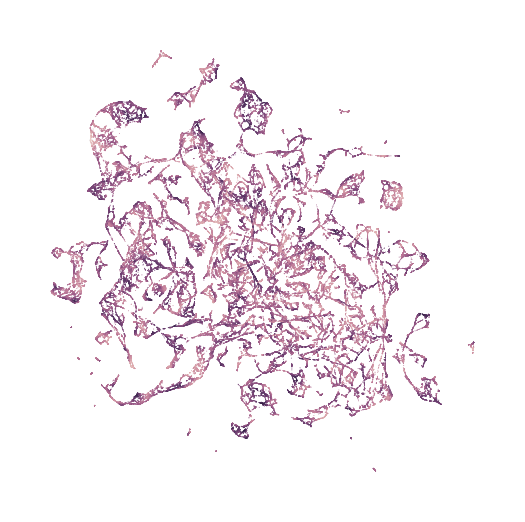

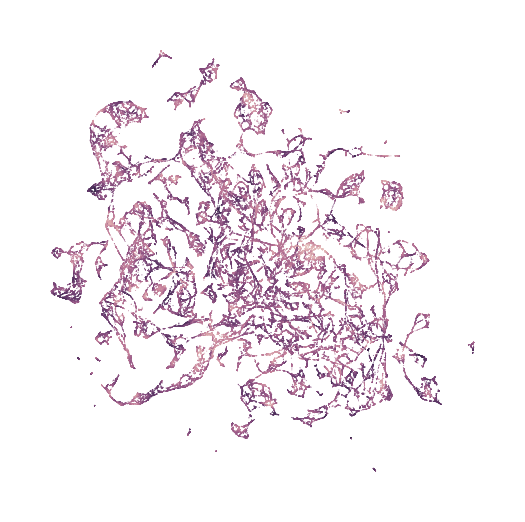

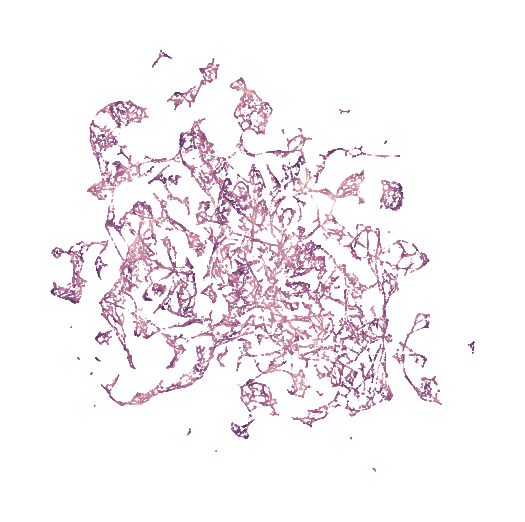

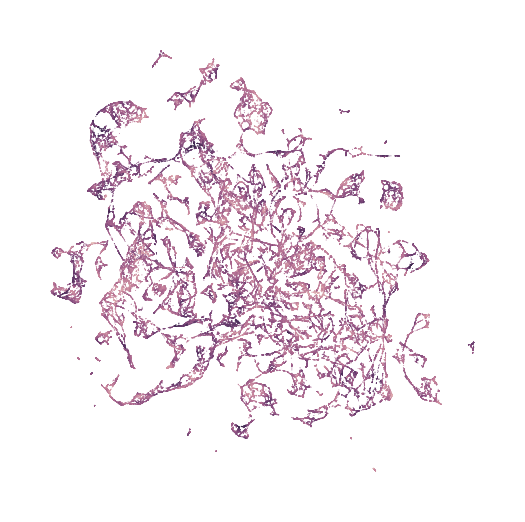

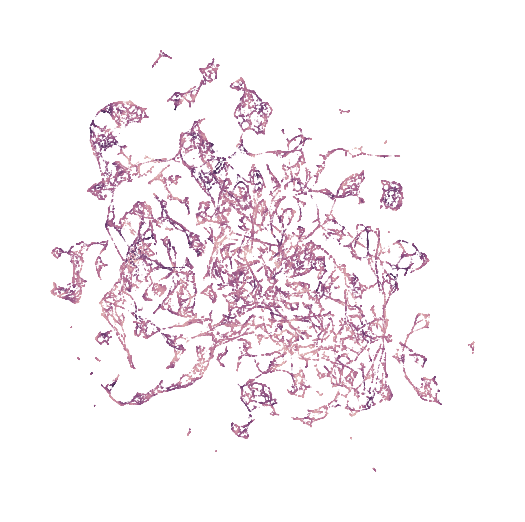

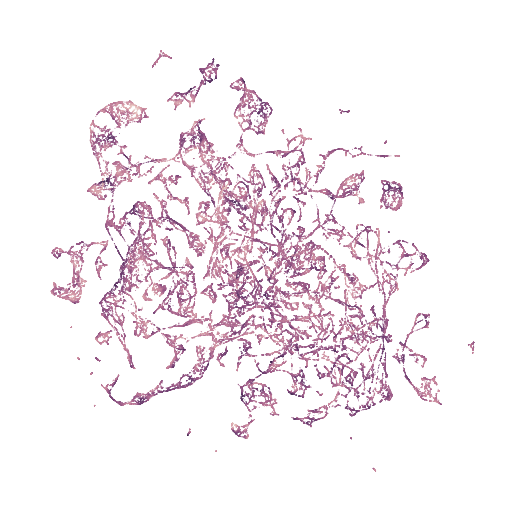

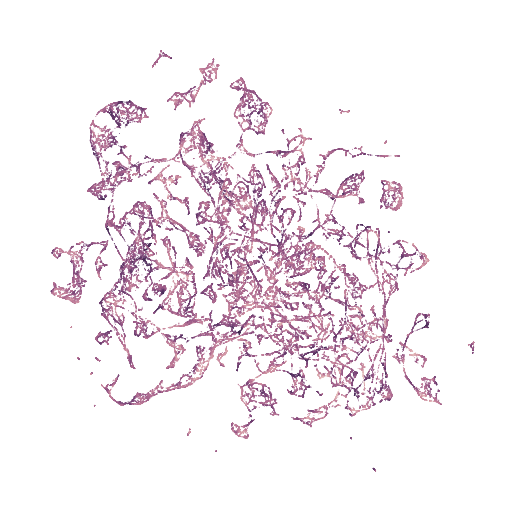

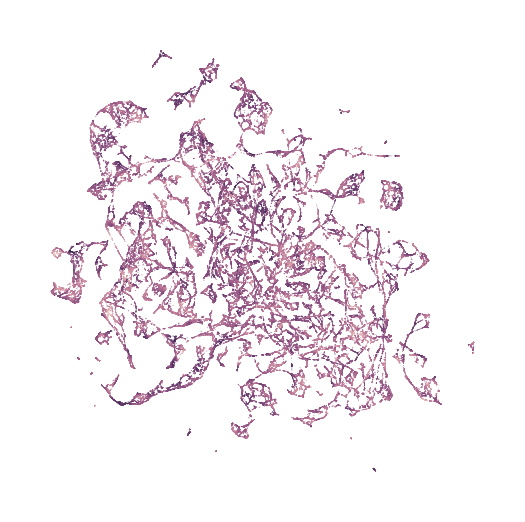

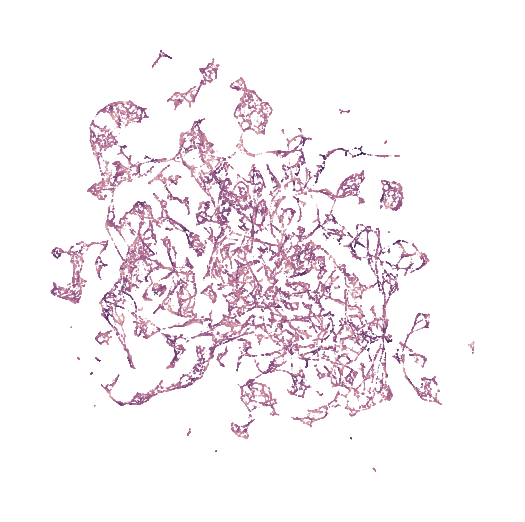

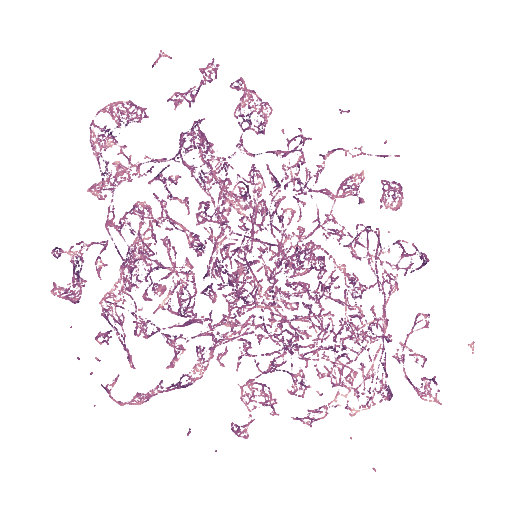

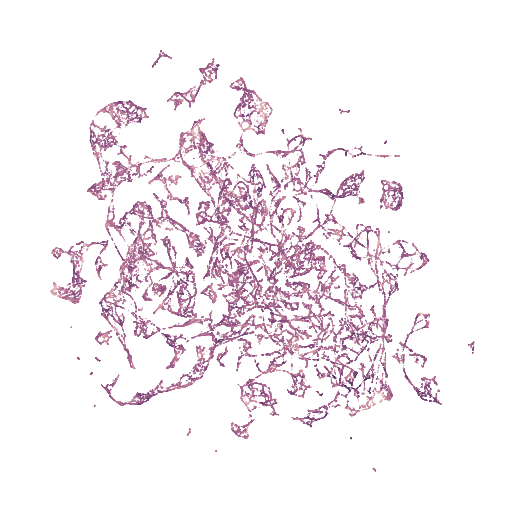

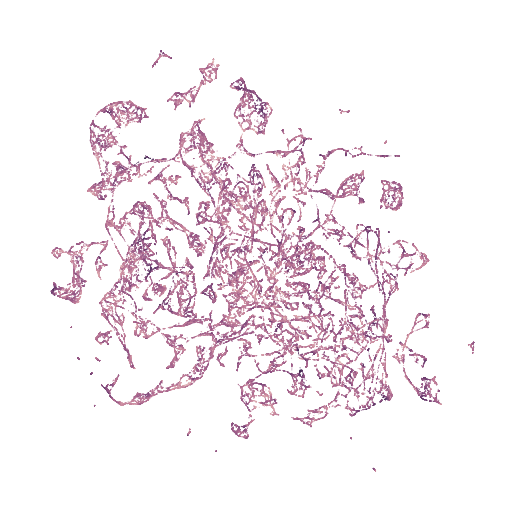

In [358]:
for i in tqdm(range(X_pca.shape[1])):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    sns.scatterplot(
        transcripts,
        x='umap_x_l4',
        y='umap_y_l4',
        hue=f'PC {i}',
        s=0.05,
        lw=0,
        ax=ax,
        legend=False,
        vmin='p1',
        vmax='p99',
    )
    ax.axis('off')

In [355]:
transcripts['umap_x_l4'] = X_umap[:, 0]
transcripts['umap_y_l4'] = X_umap[:, 1]

In [330]:
# Cluster data
model_knn = cuml.NearestNeighbors(n_neighbors=50)
model_knn.fit(cp.array(data))
neighbors, indices = model_knn.kneighbors(cp.array(data))
clusters = _run_phenograph(indices, resolution=0.2)

In [328]:
transcripts['cluster_l4'] = pd.Categorical(clusters)

In [235]:
# Get top markers used for classification
ct_model = ct.Model.load(str(data_dir / '10x_nucleus_xenium_celltypist_model.pkl'))
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)
ct_map = coefs.idxmax(1)

# Color by cell type of transcript
transcripts['cell_type'] = pd.Categorical(
    transcripts['feature_name'].map(ct_map).fillna('Unassigned')
)

In [207]:
keys = transcripts['segger_cell_id_HDE46PBXJB'].unique()
vals = keys.copy()
np.random.shuffle(keys)
transcripts['segger_cell_id_shuffled'] = pd.Categorical(transcripts['segger_cell_id_HDE46PBXJB'].map(dict(zip(keys, vals))))

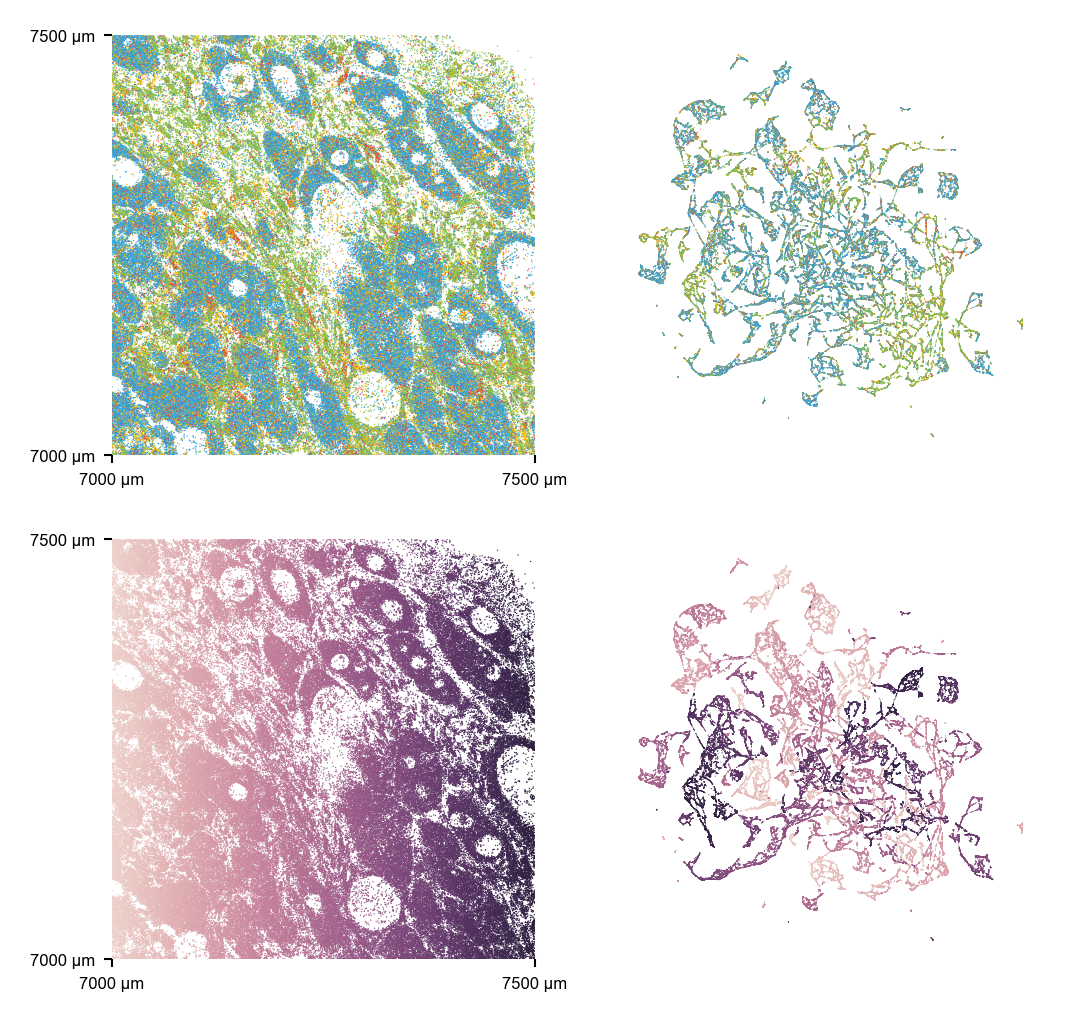

In [357]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
axes = axes.flat

mask = transcripts['cluster_l4'] != -1

col_1 = 'segger_score_HDE46PBXJB'
col_2 = 'segger_cell_id_shuffled'

col_1 = 'cell_type'
col_2 = 'x_location'
#kwargs_col_1 = dict(vmin=0.5, palette='viridis')
kwargs_col_1 = dict(palette=named_colors)
#kwargs_col_2 = dict(palette='tab20')
kwargs_col_2 = dict()

sns.scatterplot(
    transcripts[mask],
    x='umap_x_l4',
    y='umap_y_l4',
    hue=col_1,
    s=0.05,
    lw=0,
    ax=axes[1],
    legend=False,
    **kwargs_col_1,
)
axes[1].axis('off')

sns.scatterplot(
    transcripts[mask],
    x='umap_x_l4',
    y='umap_y_l4',
    hue=col_2,
    s=0.05,
    lw=0,
    ax=axes[3],
    legend=False,
    **kwargs_col_2,
)
axes[3].axis('off')
'''
for name, group in transcripts[mask].groupby('cluster', observed=True):
    axes[3].text(
        group['umap_x_l4'].mean(),
        group['umap_y_l4'].mean(),
        name,
        fontsize=5
    )
'''

sns.scatterplot(
    transcripts[mask],
    x='x_location',
    y='y_location',
    hue=col_1,
    s=0.1,
    lw=0,
    ax=axes[0],
    legend=False,
    **kwargs_col_1,
)

sns.scatterplot(
    transcripts[mask],
    x='x_location',
    y='y_location',
    hue=col_2,
    s=0.1,
    lw=0,
    ax=axes[2],
    legend=False,
    **kwargs_col_2,
)

xmin, ymin, xmax, ymax = region.bounds
for ax in (axes[0], axes[2]):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    format_ax(ax, region)

In [271]:
transcripts[f'DC 2'].std()

0.0021241177

In [274]:
ad = sc.AnnData(X=np.ones((transcripts.shape[0], 1)), obs=pd.DataFrame(index=transcripts.index))

In [295]:
ad.obsm['X_segger'] = np.array(data)

In [305]:
sc.pp.neighbors(ad, n_neighbors=15, use_rep='X_segger', method='rapids')

In [306]:
sc.tl.diffmap(ad)

In [307]:
for i in range(ad.obsm['X_diffmap'].shape[1]):
    transcripts[f'DC {i}'] = ad.obsm['X_diffmap'][:, i]

In [67]:
neural_markers = [
    "ASCL1",
    "DCLK1",
    "GFAP",
    "S100B",
    "ENO2",
    "NCAM1",
    "STMN1",
    "NEUROD1",
    "NEUROD4",
    "PHOX2B"
]